# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

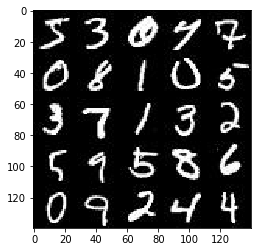

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

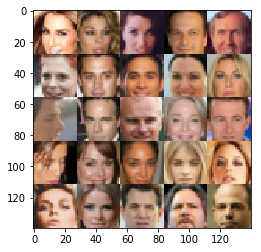

In [12]:
show_n_images = 25
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1


/Users/SichengZhou/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [14]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                'real_inputs')
    z_inputs = tf.placeholder(tf.float32,(None,z_dim),'z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return real_inputs,z_inputs,learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/Users/SichengZhou/anaconda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/Users/SichengZhou/anaconda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/Users/SichengZhou/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/Users/SichengZhou/anaconda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/Users/SichengZhou/anaconda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File "/Users/SichengZhou/anaconda/lib/python3.

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [15]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        h1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        h1 = tf.maximum(alpha * h1, h1)
    
        h2 = tf.layers.conv2d(h1, 128, 5, 2, 'same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
        
        flat = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [17]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse = not is_train):
        alpha = 0.2
    
        h1 = tf.layers.dense(z, 2*2*512)
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
    
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, 'valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
    
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
    
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [18]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [19]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, lr = model_inputs(
        img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    n_images = 25
    steps = 0
    print_every = 10
    show_every = 100
    losses = []

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                        real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                        z_input: z_sample, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 9.5099... Generator Loss: 0.0048
Epoch 1/2... Discriminator Loss: 1.9427... Generator Loss: 2.8110
Epoch 1/2... Discriminator Loss: 1.6778... Generator Loss: 2.0582
Epoch 1/2... Discriminator Loss: 2.4218... Generator Loss: 0.1320
Epoch 1/2... Discriminator Loss: 6.6907... Generator Loss: 0.0036
Epoch 1/2... Discriminator Loss: 1.0645... Generator Loss: 2.5505
Epoch 1/2... Discriminator Loss: 0.5374... Generator Loss: 2.1483
Epoch 1/2... Discriminator Loss: 0.3416... Generator Loss: 1.9732
Epoch 1/2... Discriminator Loss: 0.0359... Generator Loss: 5.8156
Epoch 1/2... Discriminator Loss: 0.2414... Generator Loss: 2.7159


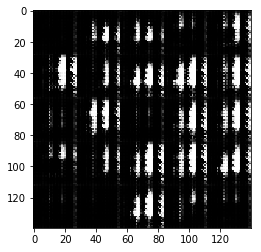

Epoch 1/2... Discriminator Loss: 0.1626... Generator Loss: 2.6804
Epoch 1/2... Discriminator Loss: 0.4064... Generator Loss: 1.8217
Epoch 1/2... Discriminator Loss: 2.1047... Generator Loss: 0.6672
Epoch 1/2... Discriminator Loss: 0.1750... Generator Loss: 3.9855
Epoch 1/2... Discriminator Loss: 0.5624... Generator Loss: 1.3923
Epoch 1/2... Discriminator Loss: 0.6597... Generator Loss: 4.6811
Epoch 1/2... Discriminator Loss: 0.6075... Generator Loss: 3.4176
Epoch 1/2... Discriminator Loss: 0.5982... Generator Loss: 2.4226
Epoch 1/2... Discriminator Loss: 0.6510... Generator Loss: 1.9253
Epoch 1/2... Discriminator Loss: 1.1675... Generator Loss: 7.0435


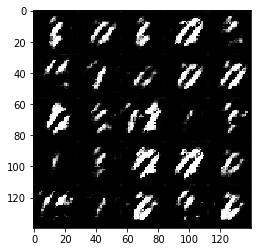

Epoch 1/2... Discriminator Loss: 1.6531... Generator Loss: 5.4078
Epoch 1/2... Discriminator Loss: 0.6602... Generator Loss: 1.9218
Epoch 1/2... Discriminator Loss: 0.5007... Generator Loss: 2.3644
Epoch 1/2... Discriminator Loss: 0.7068... Generator Loss: 2.4140
Epoch 1/2... Discriminator Loss: 0.7002... Generator Loss: 2.8558
Epoch 1/2... Discriminator Loss: 0.4540... Generator Loss: 1.7135
Epoch 1/2... Discriminator Loss: 0.3769... Generator Loss: 3.1548
Epoch 1/2... Discriminator Loss: 0.8502... Generator Loss: 1.1394
Epoch 1/2... Discriminator Loss: 0.4604... Generator Loss: 3.5800
Epoch 1/2... Discriminator Loss: 0.2946... Generator Loss: 2.4843


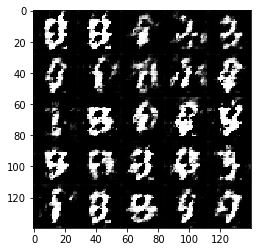

Epoch 1/2... Discriminator Loss: 0.6518... Generator Loss: 1.7355
Epoch 1/2... Discriminator Loss: 1.0645... Generator Loss: 4.2177
Epoch 1/2... Discriminator Loss: 1.5034... Generator Loss: 4.0861
Epoch 1/2... Discriminator Loss: 0.5632... Generator Loss: 1.8505
Epoch 1/2... Discriminator Loss: 1.3116... Generator Loss: 0.7636
Epoch 1/2... Discriminator Loss: 0.6119... Generator Loss: 2.0153
Epoch 1/2... Discriminator Loss: 0.6215... Generator Loss: 1.9614
Epoch 1/2... Discriminator Loss: 0.4854... Generator Loss: 1.7899
Epoch 1/2... Discriminator Loss: 1.2788... Generator Loss: 0.5770
Epoch 1/2... Discriminator Loss: 0.7425... Generator Loss: 1.0448


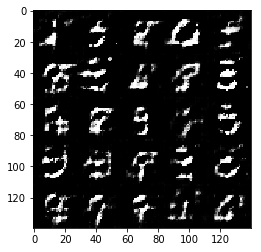

Epoch 1/2... Discriminator Loss: 0.6452... Generator Loss: 1.5891
Epoch 1/2... Discriminator Loss: 0.8462... Generator Loss: 2.1949
Epoch 1/2... Discriminator Loss: 0.5490... Generator Loss: 1.6910
Epoch 1/2... Discriminator Loss: 0.8855... Generator Loss: 0.8492
Epoch 1/2... Discriminator Loss: 0.6924... Generator Loss: 2.8252
Epoch 1/2... Discriminator Loss: 0.9341... Generator Loss: 1.2332
Epoch 1/2... Discriminator Loss: 1.2914... Generator Loss: 0.5889
Epoch 1/2... Discriminator Loss: 0.6355... Generator Loss: 1.4485
Epoch 1/2... Discriminator Loss: 1.6573... Generator Loss: 3.0134
Epoch 1/2... Discriminator Loss: 0.9666... Generator Loss: 1.6054


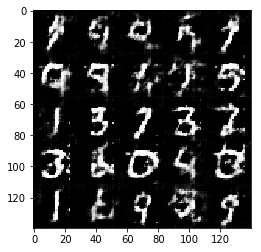

Epoch 1/2... Discriminator Loss: 1.7261... Generator Loss: 3.0238
Epoch 1/2... Discriminator Loss: 0.7509... Generator Loss: 1.6578
Epoch 1/2... Discriminator Loss: 1.3385... Generator Loss: 0.4900
Epoch 1/2... Discriminator Loss: 0.5802... Generator Loss: 1.5682
Epoch 1/2... Discriminator Loss: 0.5228... Generator Loss: 2.1735
Epoch 1/2... Discriminator Loss: 1.3214... Generator Loss: 0.5077
Epoch 1/2... Discriminator Loss: 1.2730... Generator Loss: 0.5432
Epoch 1/2... Discriminator Loss: 1.0220... Generator Loss: 2.0087
Epoch 1/2... Discriminator Loss: 1.4140... Generator Loss: 3.7037
Epoch 1/2... Discriminator Loss: 0.5980... Generator Loss: 1.5421


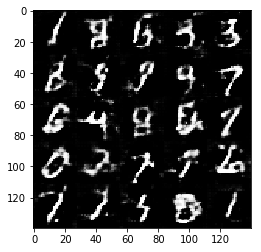

Epoch 1/2... Discriminator Loss: 0.9604... Generator Loss: 0.8626
Epoch 1/2... Discriminator Loss: 0.9172... Generator Loss: 0.9824
Epoch 1/2... Discriminator Loss: 0.7123... Generator Loss: 1.2894
Epoch 1/2... Discriminator Loss: 0.6184... Generator Loss: 1.6297
Epoch 1/2... Discriminator Loss: 0.9353... Generator Loss: 0.9394
Epoch 1/2... Discriminator Loss: 1.5766... Generator Loss: 0.4713
Epoch 1/2... Discriminator Loss: 1.0067... Generator Loss: 0.7949
Epoch 1/2... Discriminator Loss: 1.3515... Generator Loss: 0.6075
Epoch 1/2... Discriminator Loss: 0.9643... Generator Loss: 0.7765
Epoch 1/2... Discriminator Loss: 0.9262... Generator Loss: 3.2215


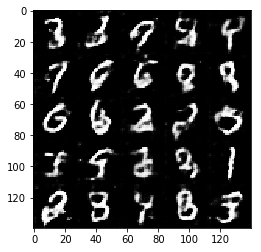

Epoch 1/2... Discriminator Loss: 1.6662... Generator Loss: 0.3700
Epoch 1/2... Discriminator Loss: 0.9895... Generator Loss: 0.8851
Epoch 1/2... Discriminator Loss: 1.0071... Generator Loss: 0.7726
Epoch 1/2... Discriminator Loss: 1.0221... Generator Loss: 2.0174
Epoch 1/2... Discriminator Loss: 0.8914... Generator Loss: 2.4510
Epoch 1/2... Discriminator Loss: 1.2162... Generator Loss: 3.1338
Epoch 1/2... Discriminator Loss: 1.5581... Generator Loss: 0.3264
Epoch 1/2... Discriminator Loss: 0.8572... Generator Loss: 1.7961
Epoch 1/2... Discriminator Loss: 1.5249... Generator Loss: 0.3581
Epoch 1/2... Discriminator Loss: 0.9411... Generator Loss: 0.9008


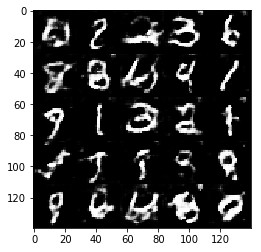

Epoch 1/2... Discriminator Loss: 0.8062... Generator Loss: 1.3211
Epoch 1/2... Discriminator Loss: 0.7278... Generator Loss: 1.6567
Epoch 1/2... Discriminator Loss: 1.3822... Generator Loss: 0.4336
Epoch 1/2... Discriminator Loss: 0.5988... Generator Loss: 1.2028
Epoch 1/2... Discriminator Loss: 1.4941... Generator Loss: 0.4242
Epoch 1/2... Discriminator Loss: 2.6137... Generator Loss: 0.2180
Epoch 1/2... Discriminator Loss: 1.8724... Generator Loss: 0.6388
Epoch 1/2... Discriminator Loss: 0.7526... Generator Loss: 1.4383
Epoch 1/2... Discriminator Loss: 0.6727... Generator Loss: 1.2825
Epoch 1/2... Discriminator Loss: 0.8096... Generator Loss: 0.9120


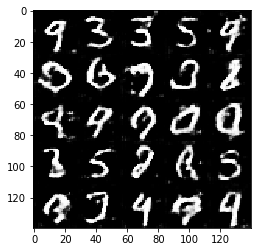

Epoch 1/2... Discriminator Loss: 0.8918... Generator Loss: 0.7286
Epoch 1/2... Discriminator Loss: 0.7772... Generator Loss: 1.1167
Epoch 1/2... Discriminator Loss: 1.6710... Generator Loss: 0.2772
Epoch 2/2... Discriminator Loss: 0.9620... Generator Loss: 0.7605
Epoch 2/2... Discriminator Loss: 0.8525... Generator Loss: 1.0728
Epoch 2/2... Discriminator Loss: 1.1661... Generator Loss: 0.8694
Epoch 2/2... Discriminator Loss: 0.9711... Generator Loss: 1.1007
Epoch 2/2... Discriminator Loss: 0.9522... Generator Loss: 0.7971
Epoch 2/2... Discriminator Loss: 0.8679... Generator Loss: 0.9288
Epoch 2/2... Discriminator Loss: 1.1182... Generator Loss: 0.7301


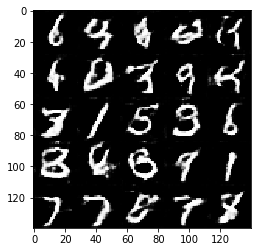

Epoch 2/2... Discriminator Loss: 1.2071... Generator Loss: 0.5834
Epoch 2/2... Discriminator Loss: 0.7604... Generator Loss: 1.4666
Epoch 2/2... Discriminator Loss: 0.6825... Generator Loss: 1.0779
Epoch 2/2... Discriminator Loss: 1.0244... Generator Loss: 0.6916
Epoch 2/2... Discriminator Loss: 1.5821... Generator Loss: 2.9280
Epoch 2/2... Discriminator Loss: 0.9507... Generator Loss: 0.9059
Epoch 2/2... Discriminator Loss: 1.0639... Generator Loss: 0.6369
Epoch 2/2... Discriminator Loss: 0.8527... Generator Loss: 1.0093
Epoch 2/2... Discriminator Loss: 1.5836... Generator Loss: 0.3947
Epoch 2/2... Discriminator Loss: 0.7164... Generator Loss: 1.4163


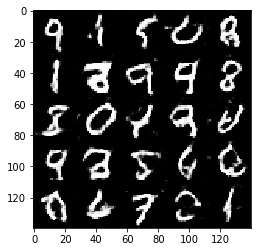

Epoch 2/2... Discriminator Loss: 0.8094... Generator Loss: 1.4905
Epoch 2/2... Discriminator Loss: 0.7645... Generator Loss: 1.3768
Epoch 2/2... Discriminator Loss: 0.7110... Generator Loss: 1.6343
Epoch 2/2... Discriminator Loss: 0.8382... Generator Loss: 0.9233
Epoch 2/2... Discriminator Loss: 0.9103... Generator Loss: 0.7522
Epoch 2/2... Discriminator Loss: 0.8684... Generator Loss: 0.9354
Epoch 2/2... Discriminator Loss: 0.9213... Generator Loss: 1.1645
Epoch 2/2... Discriminator Loss: 1.5118... Generator Loss: 0.3556
Epoch 2/2... Discriminator Loss: 1.3241... Generator Loss: 0.5769
Epoch 2/2... Discriminator Loss: 1.3910... Generator Loss: 0.5907


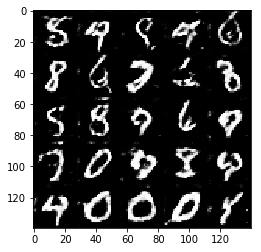

Epoch 2/2... Discriminator Loss: 1.0266... Generator Loss: 2.3564
Epoch 2/2... Discriminator Loss: 1.6383... Generator Loss: 4.4231
Epoch 2/2... Discriminator Loss: 0.9797... Generator Loss: 0.8967
Epoch 2/2... Discriminator Loss: 0.7808... Generator Loss: 1.0302
Epoch 2/2... Discriminator Loss: 0.9480... Generator Loss: 1.4459
Epoch 2/2... Discriminator Loss: 2.3408... Generator Loss: 0.1872
Epoch 2/2... Discriminator Loss: 0.9356... Generator Loss: 0.9246
Epoch 2/2... Discriminator Loss: 0.9959... Generator Loss: 0.7235
Epoch 2/2... Discriminator Loss: 0.9356... Generator Loss: 0.7849
Epoch 2/2... Discriminator Loss: 1.9580... Generator Loss: 4.2757


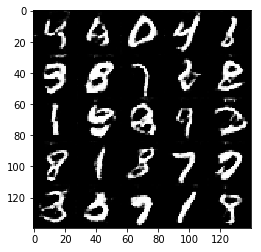

Epoch 2/2... Discriminator Loss: 0.7126... Generator Loss: 2.3494
Epoch 2/2... Discriminator Loss: 0.9411... Generator Loss: 1.6448
Epoch 2/2... Discriminator Loss: 1.0495... Generator Loss: 1.8987
Epoch 2/2... Discriminator Loss: 1.9086... Generator Loss: 0.2542
Epoch 2/2... Discriminator Loss: 1.6816... Generator Loss: 0.3702
Epoch 2/2... Discriminator Loss: 1.0072... Generator Loss: 1.5782
Epoch 2/2... Discriminator Loss: 0.7757... Generator Loss: 1.1027
Epoch 2/2... Discriminator Loss: 0.8204... Generator Loss: 0.8370
Epoch 2/2... Discriminator Loss: 0.8240... Generator Loss: 1.1669
Epoch 2/2... Discriminator Loss: 0.8805... Generator Loss: 1.1870


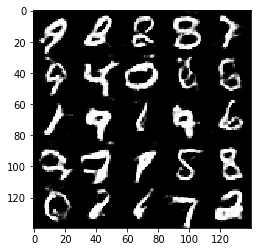

Epoch 2/2... Discriminator Loss: 0.8241... Generator Loss: 1.4189
Epoch 2/2... Discriminator Loss: 1.3063... Generator Loss: 0.5489
Epoch 2/2... Discriminator Loss: 2.0757... Generator Loss: 0.2109
Epoch 2/2... Discriminator Loss: 0.6922... Generator Loss: 1.4610
Epoch 2/2... Discriminator Loss: 1.0954... Generator Loss: 0.7475
Epoch 2/2... Discriminator Loss: 0.9340... Generator Loss: 0.8037
Epoch 2/2... Discriminator Loss: 0.9032... Generator Loss: 0.8220
Epoch 2/2... Discriminator Loss: 1.1039... Generator Loss: 0.9081
Epoch 2/2... Discriminator Loss: 0.7792... Generator Loss: 1.4895
Epoch 2/2... Discriminator Loss: 0.9411... Generator Loss: 0.8938


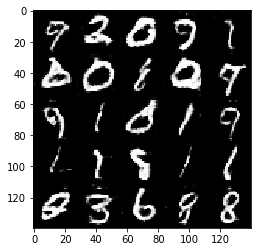

Epoch 2/2... Discriminator Loss: 1.0930... Generator Loss: 0.6524
Epoch 2/2... Discriminator Loss: 1.0404... Generator Loss: 0.7374
Epoch 2/2... Discriminator Loss: 0.6029... Generator Loss: 3.0791
Epoch 2/2... Discriminator Loss: 0.5811... Generator Loss: 1.7902
Epoch 2/2... Discriminator Loss: 0.6497... Generator Loss: 1.3213
Epoch 2/2... Discriminator Loss: 0.7753... Generator Loss: 1.9530
Epoch 2/2... Discriminator Loss: 1.6092... Generator Loss: 0.3615
Epoch 2/2... Discriminator Loss: 1.1149... Generator Loss: 2.5710
Epoch 2/2... Discriminator Loss: 2.3532... Generator Loss: 0.2097
Epoch 2/2... Discriminator Loss: 1.1007... Generator Loss: 1.2136


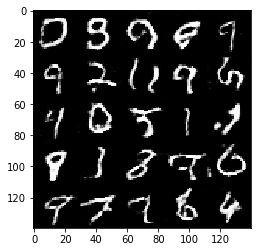

Epoch 2/2... Discriminator Loss: 0.9704... Generator Loss: 0.8713
Epoch 2/2... Discriminator Loss: 0.6229... Generator Loss: 1.6544
Epoch 2/2... Discriminator Loss: 0.5884... Generator Loss: 2.4343
Epoch 2/2... Discriminator Loss: 1.7585... Generator Loss: 0.4292
Epoch 2/2... Discriminator Loss: 1.5678... Generator Loss: 0.3574
Epoch 2/2... Discriminator Loss: 0.8688... Generator Loss: 0.9236
Epoch 2/2... Discriminator Loss: 1.6678... Generator Loss: 0.3730
Epoch 2/2... Discriminator Loss: 0.6180... Generator Loss: 1.3033
Epoch 2/2... Discriminator Loss: 1.1200... Generator Loss: 0.6091
Epoch 2/2... Discriminator Loss: 1.6260... Generator Loss: 0.3357


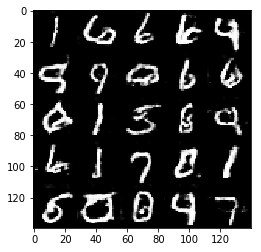

Epoch 2/2... Discriminator Loss: 1.1563... Generator Loss: 0.6319
Epoch 2/2... Discriminator Loss: 1.5985... Generator Loss: 0.4422
Epoch 2/2... Discriminator Loss: 1.0990... Generator Loss: 1.3770
Epoch 2/2... Discriminator Loss: 0.6488... Generator Loss: 1.3916
Epoch 2/2... Discriminator Loss: 1.2317... Generator Loss: 2.5738
Epoch 2/2... Discriminator Loss: 0.6132... Generator Loss: 1.3764
Epoch 2/2... Discriminator Loss: 1.5640... Generator Loss: 0.4234
Epoch 2/2... Discriminator Loss: 1.3208... Generator Loss: 0.7183
Epoch 2/2... Discriminator Loss: 0.4940... Generator Loss: 1.7438
Epoch 2/2... Discriminator Loss: 1.2256... Generator Loss: 0.7010


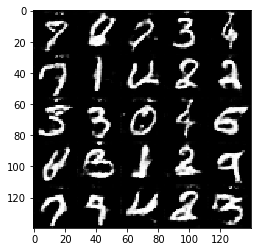

Epoch 2/2... Discriminator Loss: 0.9709... Generator Loss: 1.0267
Epoch 2/2... Discriminator Loss: 1.0017... Generator Loss: 0.7801
Epoch 2/2... Discriminator Loss: 1.8434... Generator Loss: 0.4096
Epoch 2/2... Discriminator Loss: 1.3017... Generator Loss: 0.5155
Epoch 2/2... Discriminator Loss: 0.8840... Generator Loss: 1.0955
Epoch 2/2... Discriminator Loss: 0.9160... Generator Loss: 0.9082
Epoch 2/2... Discriminator Loss: 1.0877... Generator Loss: 0.6528


In [24]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 11.4660... Generator Loss: 0.0002
Epoch 1/1... Discriminator Loss: 0.3899... Generator Loss: 2.9006
Epoch 1/1... Discriminator Loss: 0.6760... Generator Loss: 2.2290
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 0.5544
Epoch 1/1... Discriminator Loss: 0.4457... Generator Loss: 2.3728
Epoch 1/1... Discriminator Loss: 2.0366... Generator Loss: 7.4013
Epoch 1/1... Discriminator Loss: 0.7865... Generator Loss: 4.2184
Epoch 1/1... Discriminator Loss: 1.4984... Generator Loss: 7.9012
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 5.8723
Epoch 1/1... Discriminator Loss: 0.3504... Generator Loss: 2.5543


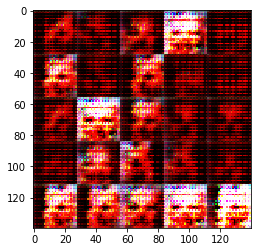

Epoch 1/1... Discriminator Loss: 0.2128... Generator Loss: 3.0489
Epoch 1/1... Discriminator Loss: 2.4383... Generator Loss: 12.1315
Epoch 1/1... Discriminator Loss: 0.0705... Generator Loss: 5.7232
Epoch 1/1... Discriminator Loss: 0.6912... Generator Loss: 1.3633
Epoch 1/1... Discriminator Loss: 2.3547... Generator Loss: 8.5827
Epoch 1/1... Discriminator Loss: 0.2181... Generator Loss: 2.9739
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 0.8643... Generator Loss: 1.1500
Epoch 1/1... Discriminator Loss: 0.3564... Generator Loss: 1.3570
Epoch 1/1... Discriminator Loss: 1.0277... Generator Loss: 3.7078


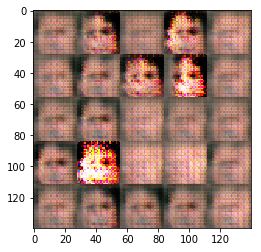

Epoch 1/1... Discriminator Loss: 0.2059... Generator Loss: 2.3125
Epoch 1/1... Discriminator Loss: 2.6954... Generator Loss: 5.1698
Epoch 1/1... Discriminator Loss: 0.5368... Generator Loss: 1.7761
Epoch 1/1... Discriminator Loss: 0.8074... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.7193... Generator Loss: 2.5907
Epoch 1/1... Discriminator Loss: 1.6082... Generator Loss: 4.2984
Epoch 1/1... Discriminator Loss: 0.8344... Generator Loss: 0.9909
Epoch 1/1... Discriminator Loss: 0.6802... Generator Loss: 2.1305
Epoch 1/1... Discriminator Loss: 3.5249... Generator Loss: 4.7515
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 1.7887


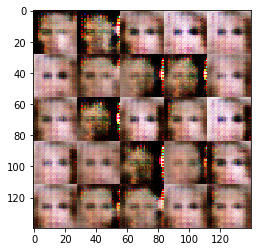

Epoch 1/1... Discriminator Loss: 0.7999... Generator Loss: 1.4567
Epoch 1/1... Discriminator Loss: 1.0452... Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 0.8091... Generator Loss: 1.4457
Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 2.1075... Generator Loss: 0.3806
Epoch 1/1... Discriminator Loss: 0.9436... Generator Loss: 1.5596
Epoch 1/1... Discriminator Loss: 0.9503... Generator Loss: 1.7808
Epoch 1/1... Discriminator Loss: 1.6809... Generator Loss: 3.1386
Epoch 1/1... Discriminator Loss: 3.9402... Generator Loss: 4.2413
Epoch 1/1... Discriminator Loss: 0.9925... Generator Loss: 1.0600


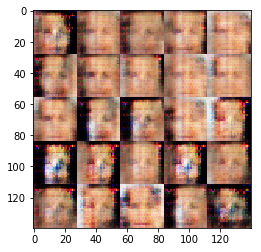

Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 1.1894
Epoch 1/1... Discriminator Loss: 0.9779... Generator Loss: 0.8372
Epoch 1/1... Discriminator Loss: 0.7165... Generator Loss: 1.1521
Epoch 1/1... Discriminator Loss: 0.9864... Generator Loss: 1.6526
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 1.3665
Epoch 1/1... Discriminator Loss: 0.9825... Generator Loss: 0.8376
Epoch 1/1... Discriminator Loss: 1.1533... Generator Loss: 1.0187
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.5830
Epoch 1/1... Discriminator Loss: 0.8570... Generator Loss: 1.4254
Epoch 1/1... Discriminator Loss: 1.0907... Generator Loss: 0.6719


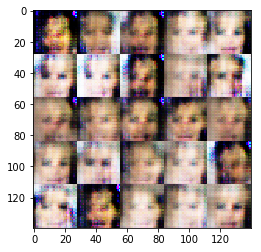

Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 1.5407
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.4541
Epoch 1/1... Discriminator Loss: 0.9550... Generator Loss: 1.5422
Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 0.7217... Generator Loss: 1.1708
Epoch 1/1... Discriminator Loss: 0.9171... Generator Loss: 1.5950
Epoch 1/1... Discriminator Loss: 1.1885... Generator Loss: 2.7861
Epoch 1/1... Discriminator Loss: 1.1416... Generator Loss: 1.8934
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 0.6802
Epoch 1/1... Discriminator Loss: 1.9615... Generator Loss: 0.2505


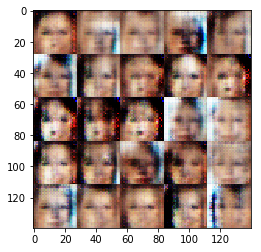

Epoch 1/1... Discriminator Loss: 1.0785... Generator Loss: 1.1391
Epoch 1/1... Discriminator Loss: 1.0209... Generator Loss: 0.8874
Epoch 1/1... Discriminator Loss: 0.9668... Generator Loss: 0.9290
Epoch 1/1... Discriminator Loss: 0.8448... Generator Loss: 1.1017
Epoch 1/1... Discriminator Loss: 1.1280... Generator Loss: 0.9002
Epoch 1/1... Discriminator Loss: 1.0760... Generator Loss: 0.6530
Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 0.5604
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 1.9973
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 1.0212
Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.6087


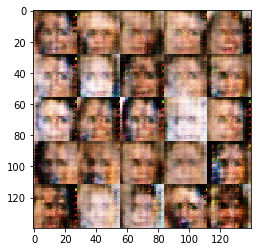

Epoch 1/1... Discriminator Loss: 0.9420... Generator Loss: 1.4631
Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 0.8269... Generator Loss: 1.4035
Epoch 1/1... Discriminator Loss: 0.9299... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 0.9802... Generator Loss: 1.2329
Epoch 1/1... Discriminator Loss: 0.9899... Generator Loss: 1.0895
Epoch 1/1... Discriminator Loss: 1.0247... Generator Loss: 1.3096
Epoch 1/1... Discriminator Loss: 1.0093... Generator Loss: 0.8439
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 1.5216
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 0.5591


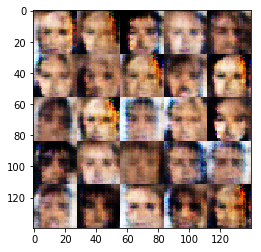

Epoch 1/1... Discriminator Loss: 1.0398... Generator Loss: 0.9515
Epoch 1/1... Discriminator Loss: 1.0159... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 0.9317... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 1.1751... Generator Loss: 1.2746
Epoch 1/1... Discriminator Loss: 1.5262... Generator Loss: 0.4115
Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.0270... Generator Loss: 1.0292
Epoch 1/1... Discriminator Loss: 0.7875... Generator Loss: 1.1844
Epoch 1/1... Discriminator Loss: 2.4232... Generator Loss: 0.1377
Epoch 1/1... Discriminator Loss: 1.0680... Generator Loss: 0.7262


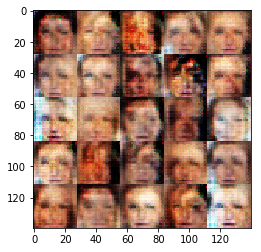

Epoch 1/1... Discriminator Loss: 1.0715... Generator Loss: 1.9167
Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 1.2525
Epoch 1/1... Discriminator Loss: 0.7504... Generator Loss: 1.1451
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 1.3292
Epoch 1/1... Discriminator Loss: 1.0044... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 1.5383... Generator Loss: 0.3822
Epoch 1/1... Discriminator Loss: 0.9517... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.8648... Generator Loss: 3.4481
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.4175


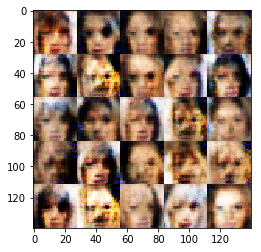

Epoch 1/1... Discriminator Loss: 0.9431... Generator Loss: 1.6639
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.4951
Epoch 1/1... Discriminator Loss: 2.1014... Generator Loss: 0.2357
Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 0.5428
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.4832
Epoch 1/1... Discriminator Loss: 0.9978... Generator Loss: 0.9021
Epoch 1/1... Discriminator Loss: 0.8943... Generator Loss: 1.2300
Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 0.4516
Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 0.8330


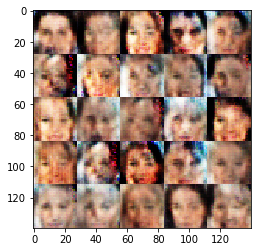

Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 0.9101
Epoch 1/1... Discriminator Loss: 1.1730... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 0.9436... Generator Loss: 0.9828
Epoch 1/1... Discriminator Loss: 1.1670... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 0.9820... Generator Loss: 1.3524
Epoch 1/1... Discriminator Loss: 1.0392... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 2.1166
Epoch 1/1... Discriminator Loss: 0.9507... Generator Loss: 1.2324
Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 0.9905... Generator Loss: 2.0974


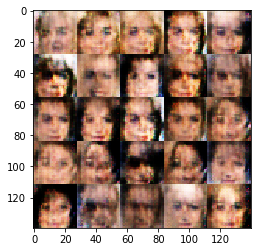

Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 0.6332
Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 1.0554
Epoch 1/1... Discriminator Loss: 0.8084... Generator Loss: 1.4899
Epoch 1/1... Discriminator Loss: 0.7393... Generator Loss: 1.1752
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.4701
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.4794
Epoch 1/1... Discriminator Loss: 1.0370... Generator Loss: 1.2891
Epoch 1/1... Discriminator Loss: 1.8498... Generator Loss: 2.2097
Epoch 1/1... Discriminator Loss: 1.1214... Generator Loss: 1.0302
Epoch 1/1... Discriminator Loss: 0.8544... Generator Loss: 1.1753


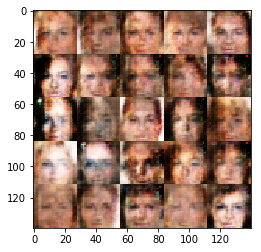

Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 2.0981
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 1.4427
Epoch 1/1... Discriminator Loss: 1.0611... Generator Loss: 1.0476
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.6057
Epoch 1/1... Discriminator Loss: 0.8642... Generator Loss: 1.0157
Epoch 1/1... Discriminator Loss: 0.9361... Generator Loss: 1.3597
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 1.1009
Epoch 1/1... Discriminator Loss: 1.1056... Generator Loss: 1.9849
Epoch 1/1... Discriminator Loss: 0.8670... Generator Loss: 1.2815


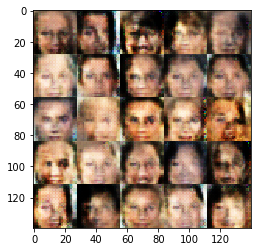

Epoch 1/1... Discriminator Loss: 1.1907... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 0.4982
Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 1.7420
Epoch 1/1... Discriminator Loss: 1.0189... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 0.9543
Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 1.5685... Generator Loss: 0.4674
Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 0.9676
Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 1.0393
Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 0.8500


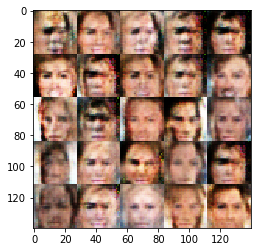

Epoch 1/1... Discriminator Loss: 1.0912... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.0577... Generator Loss: 1.2690
Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 0.5987
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 0.9520... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 0.7047... Generator Loss: 1.0861
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.5223
Epoch 1/1... Discriminator Loss: 1.4983... Generator Loss: 1.5438
Epoch 1/1... Discriminator Loss: 1.1841... Generator Loss: 0.6059
Epoch 1/1... Discriminator Loss: 1.1430... Generator Loss: 0.7950


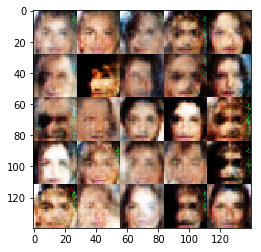

Epoch 1/1... Discriminator Loss: 1.0108... Generator Loss: 1.7129
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.0760... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.3773
Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 1.6146
Epoch 1/1... Discriminator Loss: 1.1384... Generator Loss: 1.0124
Epoch 1/1... Discriminator Loss: 1.0894... Generator Loss: 2.4315
Epoch 1/1... Discriminator Loss: 0.9554... Generator Loss: 1.9691
Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 1.8320
Epoch 1/1... Discriminator Loss: 1.9913... Generator Loss: 0.2022


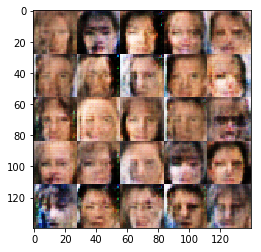

Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 0.9480... Generator Loss: 0.8656
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 1.6963
Epoch 1/1... Discriminator Loss: 1.0074... Generator Loss: 1.9878
Epoch 1/1... Discriminator Loss: 0.8196... Generator Loss: 1.4442
Epoch 1/1... Discriminator Loss: 2.0813... Generator Loss: 0.2276
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.4478
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.4115
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.5311


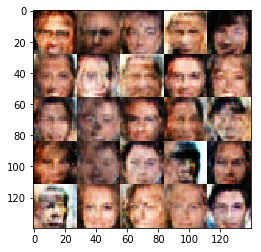

Epoch 1/1... Discriminator Loss: 1.0146... Generator Loss: 1.4467
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 0.4889
Epoch 1/1... Discriminator Loss: 0.9147... Generator Loss: 1.1599
Epoch 1/1... Discriminator Loss: 0.7572... Generator Loss: 1.0061
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 1.4023
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.4563
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.6086
Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.8658... Generator Loss: 1.7463
Epoch 1/1... Discriminator Loss: 0.8334... Generator Loss: 0.9223


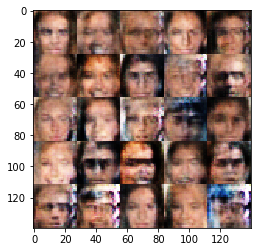

Epoch 1/1... Discriminator Loss: 1.0100... Generator Loss: 0.9356
Epoch 1/1... Discriminator Loss: 0.9638... Generator Loss: 0.8794
Epoch 1/1... Discriminator Loss: 1.4777... Generator Loss: 0.4874
Epoch 1/1... Discriminator Loss: 1.0538... Generator Loss: 1.1804
Epoch 1/1... Discriminator Loss: 1.6661... Generator Loss: 0.3652
Epoch 1/1... Discriminator Loss: 0.9502... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.6394... Generator Loss: 0.3264
Epoch 1/1... Discriminator Loss: 1.0464... Generator Loss: 1.0343
Epoch 1/1... Discriminator Loss: 1.0094... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 0.9529... Generator Loss: 1.1962


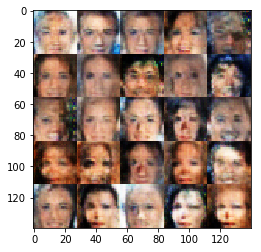

Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 0.5917
Epoch 1/1... Discriminator Loss: 1.0878... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 0.9966... Generator Loss: 1.2130
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.5686
Epoch 1/1... Discriminator Loss: 1.1146... Generator Loss: 1.4064
Epoch 1/1... Discriminator Loss: 2.2556... Generator Loss: 2.8439
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 0.8869... Generator Loss: 0.9976
Epoch 1/1... Discriminator Loss: 1.0454... Generator Loss: 1.0436
Epoch 1/1... Discriminator Loss: 0.9875... Generator Loss: 0.9219


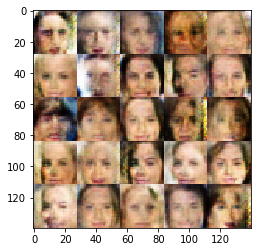

Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 0.4969
Epoch 1/1... Discriminator Loss: 1.0571... Generator Loss: 0.9023
Epoch 1/1... Discriminator Loss: 1.5548... Generator Loss: 1.6626
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.4960
Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 0.6047
Epoch 1/1... Discriminator Loss: 0.8975... Generator Loss: 0.9940
Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.5439
Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 0.8204


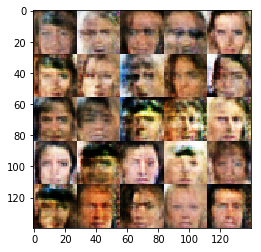

Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.4507
Epoch 1/1... Discriminator Loss: 1.0247... Generator Loss: 0.8491
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 0.9230... Generator Loss: 1.2619
Epoch 1/1... Discriminator Loss: 1.2071... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 0.9839... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 0.5713
Epoch 1/1... Discriminator Loss: 0.9808... Generator Loss: 1.0565
Epoch 1/1... Discriminator Loss: 0.9379... Generator Loss: 1.0641
Epoch 1/1... Discriminator Loss: 0.7442... Generator Loss: 1.5934


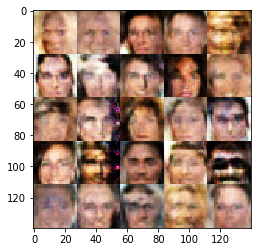

Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 2.3858
Epoch 1/1... Discriminator Loss: 1.1704... Generator Loss: 2.1794
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 0.5712
Epoch 1/1... Discriminator Loss: 0.7591... Generator Loss: 1.5132
Epoch 1/1... Discriminator Loss: 0.9055... Generator Loss: 1.1769
Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 0.6071
Epoch 1/1... Discriminator Loss: 0.9334... Generator Loss: 1.1479
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 1.0170
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 0.9791


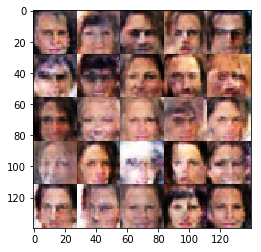

Epoch 1/1... Discriminator Loss: 0.9186... Generator Loss: 1.3745
Epoch 1/1... Discriminator Loss: 1.0490... Generator Loss: 1.0074
Epoch 1/1... Discriminator Loss: 1.0416... Generator Loss: 1.8971
Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 1.7752
Epoch 1/1... Discriminator Loss: 0.9374... Generator Loss: 1.1053
Epoch 1/1... Discriminator Loss: 1.0087... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.0374... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.0710... Generator Loss: 0.9243
Epoch 1/1... Discriminator Loss: 1.0402... Generator Loss: 1.3490
Epoch 1/1... Discriminator Loss: 0.9026... Generator Loss: 0.9080


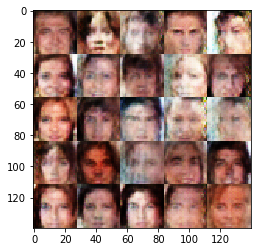

Epoch 1/1... Discriminator Loss: 0.9597... Generator Loss: 1.0573
Epoch 1/1... Discriminator Loss: 0.9626... Generator Loss: 1.2952
Epoch 1/1... Discriminator Loss: 0.8403... Generator Loss: 1.0420
Epoch 1/1... Discriminator Loss: 0.9471... Generator Loss: 1.1324
Epoch 1/1... Discriminator Loss: 2.7298... Generator Loss: 3.5029
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 1.3311
Epoch 1/1... Discriminator Loss: 1.1071... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 0.9174... Generator Loss: 1.1431
Epoch 1/1... Discriminator Loss: 0.8751... Generator Loss: 1.3033
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.5252


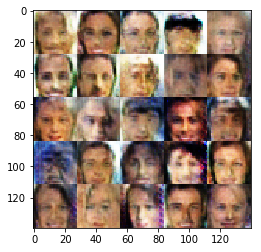

Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 1.1455
Epoch 1/1... Discriminator Loss: 1.0542... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 0.9915... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 0.8529... Generator Loss: 0.9824
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 0.8102
Epoch 1/1... Discriminator Loss: 1.0741... Generator Loss: 1.3355
Epoch 1/1... Discriminator Loss: 1.1085... Generator Loss: 1.3025
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.5350
Epoch 1/1... Discriminator Loss: 0.9218... Generator Loss: 0.9843
Epoch 1/1... Discriminator Loss: 0.9861... Generator Loss: 0.8479


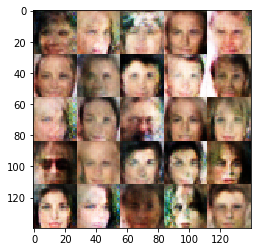

Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 1.6192
Epoch 1/1... Discriminator Loss: 0.9033... Generator Loss: 1.1513
Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 0.6086
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.4855
Epoch 1/1... Discriminator Loss: 0.9384... Generator Loss: 1.2458
Epoch 1/1... Discriminator Loss: 0.9382... Generator Loss: 0.9217
Epoch 1/1... Discriminator Loss: 0.9912... Generator Loss: 1.2691
Epoch 1/1... Discriminator Loss: 0.8995... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 0.8164


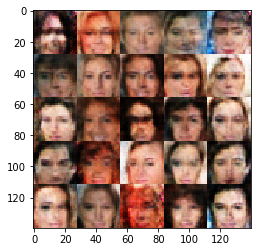

Epoch 1/1... Discriminator Loss: 0.8610... Generator Loss: 1.0410
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 1.4878
Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 0.9959... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.0136... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.0610... Generator Loss: 1.4949
Epoch 1/1... Discriminator Loss: 1.0257... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 0.9982... Generator Loss: 1.1220
Epoch 1/1... Discriminator Loss: 0.8116... Generator Loss: 1.7190
Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 0.9753


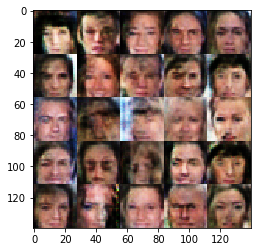

Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 1.6530
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.4789
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.4164
Epoch 1/1... Discriminator Loss: 0.9025... Generator Loss: 0.9848
Epoch 1/1... Discriminator Loss: 1.0118... Generator Loss: 0.8751
Epoch 1/1... Discriminator Loss: 0.9171... Generator Loss: 1.1515
Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 1.0534
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 1.0919... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.9296... Generator Loss: 0.2287


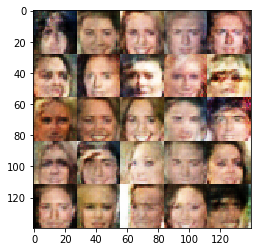

Epoch 1/1... Discriminator Loss: 0.9948... Generator Loss: 2.0152
Epoch 1/1... Discriminator Loss: 1.0836... Generator Loss: 0.9917
Epoch 1/1... Discriminator Loss: 0.9807... Generator Loss: 0.8588
Epoch 1/1... Discriminator Loss: 1.4763... Generator Loss: 0.3791
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.4401
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 0.9306
Epoch 1/1... Discriminator Loss: 1.0341... Generator Loss: 1.0761
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 1.8464
Epoch 1/1... Discriminator Loss: 1.1040... Generator Loss: 0.7290
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.5169


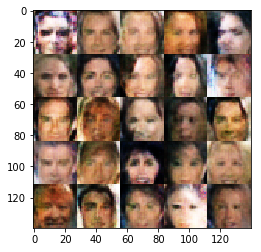

Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 0.9303
Epoch 1/1... Discriminator Loss: 1.0024... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 0.9317... Generator Loss: 0.9072
Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.6114... Generator Loss: 0.3200


In [25]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.